DISEASE OUTBREAK PREDICTION VIA SOCIAL MEDIA 

importing necessary libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from datetime import datetime, timezone
nltk.download('wordnet') #lexical database
# import locationtagger
# import spacy
#import dask.dataframe as dd # parallel processing for pandas (to read large datasets) fixed memory issue 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kedar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Loading

In [2]:
# reading comments dataset (do not have enough computational power and memory space to read the entire dataset)
data_comments = pd.read_csv('C:\\Users\\kedar\\OneDrive\\Desktop\\ML mini project\\DiseaseOutbreak_Dataset\\the-reddit-covid-dataset-comments.csv', nrows=1000000)

In [3]:
#checking whether the data loaded
data_comments.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,hi1vsag,2riyy,nova,False,1635206399,https://old.reddit.com/r/nova/comments/qfs53d/...,When you scheduled your booster with CVS does ...,0.0000,2
1,comment,hi1vs7i,2qhov,vancouver,False,1635206397,https://old.reddit.com/r/vancouver/comments/qf...,Didn't stop prices there though. New Zealand a...,0.1887,32
2,comment,hi1vs5n,2qwzb,pregnant,False,1635206397,https://old.reddit.com/r/pregnant/comments/qfs...,I’m just waiting until after pregnancy to get ...,0.6720,1
3,comment,hi1vs5v,2qixm,startrek,False,1635206397,https://old.reddit.com/r/startrek/comments/qft...,*The first duty of every Starfleet officer is ...,0.9562,1
4,comment,hi1vs0l,2qsf3,ontario,False,1635206395,https://old.reddit.com/r/ontario/comments/qfkj...,Compare BC to Ontario for COVID. It's even mor...,0.0000,-2


In [4]:
data_stats = pd.read_csv('WHO-COVID-19-global-data.csv')

In [5]:
data_stats.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


Data Pre-processing

handling missing values

In [6]:
nan_stats = data_stats.isna().sum()
print('Nan values in column of Comments dataset: ',nan_stats)
nan_comments = data_comments.isna().sum()
print('Nan values in column of Comments dataset: ',nan_comments)

Nan values in column of Comments dataset:  Date_reported           0
Country_code         1407
Country                 0
WHO_region              0
New_cases               0
Cumulative_cases        0
New_deaths              0
Cumulative_deaths       0
dtype: int64
Nan values in column of Comments dataset:  type                  0
id                    0
subreddit.id          0
subreddit.name        0
subreddit.nsfw        0
created_utc           0
permalink             0
body                  0
sentiment         37937
score                 0
dtype: int64


conclusions:
1) comments dataset: sentiments has too many missing values - drop column
2) stats dataset: Country_code has too many missing values
3) dropping type,id, subreddit.id, subreddit.name,subreddit.nsfw, permalink since they aren't relevant to the prediction of disease outbreak (logically)

In [7]:
data_stats = data_stats.drop(columns = 'Country_code')
data_comments = data_comments.drop(columns = 'sentiment')

data_comments = data_comments.drop(columns = ['type','id','subreddit.id','subreddit.nsfw', 'permalink'])

In [8]:
# converting all utc objects to date-time objects
data_comments['created_utc'] = pd.to_datetime(data_comments['created_utc'], unit='s', utc=True)
data_stats['Date_reported'] = pd.to_datetime(data_stats['Date_reported'], errors='coerce')

In [9]:
# re analaysing:\n",
nan_stats = data_stats.isna().sum()
print('Nan values in column of Comments dataset: ',nan_stats)
nan_comments = data_comments.isna().sum()
print('Nan values in column of Comments dataset: ',nan_comments)

Nan values in column of Comments dataset:  Date_reported        0
Country              0
WHO_region           0
New_cases            0
Cumulative_cases     0
New_deaths           0
Cumulative_deaths    0
dtype: int64
Nan values in column of Comments dataset:  subreddit.name    0
created_utc       0
body              0
score             0
dtype: int64


Temporal Analysis - Daily Granularity

In [10]:
import pandas as pd

# Set the total population
total_population = 7800000000 

# Day, Month, Year extraction
data_stats['Date_reported'] = pd.to_datetime(data_stats['Date_reported'])
data_stats['Day'] = data_stats['Date_reported'].dt.day
data_stats['Month'] = data_stats['Date_reported'].dt.month
data_stats['Year'] = data_stats['Date_reported'].dt.year

# Grouping data by Year, Month, and Day, and calculating aggregated statistics
daily_stats = data_stats.groupby(['Year', 'Month', 'Day']).agg({
    'New_cases': 'sum',
    'Cumulative_cases': 'max',  
    'New_deaths': 'sum',
    'Cumulative_deaths': 'max'  
}).reset_index()

# Calculating the percentage of outbreak for each day
daily_stats['Percentage_outbreak'] = (daily_stats['Cumulative_cases'] / total_population) * 100

# Display the DataFrame with daily granularity
print(daily_stats)

      Year  Month  Day  New_cases  Cumulative_cases  New_deaths  \
0     2020      1    3          0                 0           0   
1     2020      1    4          3                 1           0   
2     2020      1    5         -1                 1           3   
3     2020      1    6          3                 4           0   
4     2020      1    7          0                 4           0   
...    ...    ...  ...        ...               ...         ...   
1402  2023     11    5       3747         103436829         108   
1403  2023     11    6          0         103436829           0   
1404  2023     11    7          0         103436829           0   
1405  2023     11    8          0         103436829           0   
1406  2023     11    9          0         103436829           0   

      Cumulative_deaths  Percentage_outbreak  
0                     0         0.000000e+00  
1                     0         1.282051e-08  
2                     3         1.282051e-08  
3      

visualising daily statistical data vs. COVID outbreak percentage

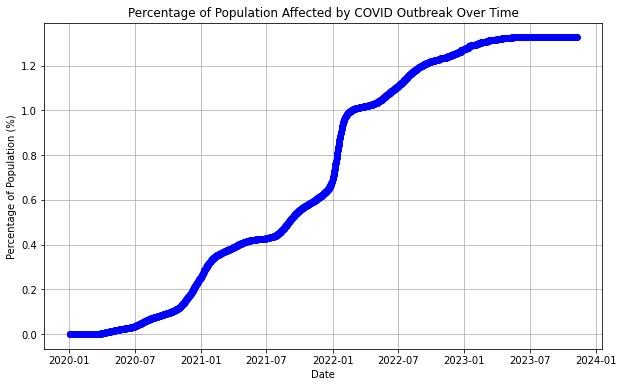

In [50]:
daily_stats['Date'] = pd.to_datetime(daily_stats[['Year', 'Month', 'Day']])

# Plotting the percentage outbreak vs time
plt.figure(figsize=(10, 6))
plt.plot(daily_stats['Date'], daily_stats['Percentage_outbreak'], marker='o', linestyle='-', color='b')
plt.title('Percentage of Population Affected by COVID Outbreak Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Population (%)')
plt.grid(True)
plt.show()

In [11]:
# # Assuming you have the thresholds defined as follows:
# low_threshold = 0.1
# moderate_threshold = 0.5

# # Assuming you have a DataFrame named 'monthly_stats' with columns: 'Year', 'Month', 'Percentage_outbreak'

# # Create a new column 'Outbreak_Risk' and label each month
# daily_stats['Outbreak_Risk'] = pd.cut(
#     daily_stats['Percentage_outbreak'],
#     bins=[0, low_threshold, moderate_threshold, float('inf')],
#     labels=['Low', 'Moderate', 'High']
# )

# # Display the result
# print(daily_stats[['Year', 'Month', 'Percentage_outbreak', 'Outbreak_Risk']])

      Year  Month  Percentage_outbreak Outbreak_Risk
0     2020      1         0.000000e+00           NaN
1     2020      1         1.282051e-08           Low
2     2020      1         1.282051e-08           Low
3     2020      1         5.128205e-08           Low
4     2020      1         5.128205e-08           Low
...    ...    ...                  ...           ...
1402  2023     11         1.326113e+00          High
1403  2023     11         1.326113e+00          High
1404  2023     11         1.326113e+00          High
1405  2023     11         1.326113e+00          High
1406  2023     11         1.326113e+00          High

[1407 rows x 4 columns]


Sentiment Analysis

In [12]:
import nltk # natural language toolkit
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize # breaking down text into individual tokens
from nltk.corpus import stopwords

# resources
nltk.download('vader_lexicon') #Valence Aware Dictionary and Sentiment reasoner (list of words with associated sentiment scores)
nltk.download('punkt') # pre-trained unsupervised model for tokenization - word_tokenize (individual words), sent_tokenize(paragraph to sentences)
nltk.download('stopwords') # little value words like articles, conjunctions and so on...

# Load the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()


# Function to perform sentiment analysis on a text and return the compound score
def analyze_sentiment(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    #converting words to lowercase letters only
    words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
    
    # Calculate sentiment scores
    sentiment_scores = sid.polarity_scores(' '.join(words)) #polarity_scores generates a dictionary for positive negative and neutral and overall compund score
    
    # print('sentiment score:', sentiment_scores['compound'])
    # Return the compound score
    return sentiment_scores['compound']

# Apply sentiment analysis to the 'body' column
data_comments['Sentiment_Score'] = data_comments['body'].apply(analyze_sentiment)

# Display the result
print(data_comments[['body', 'Sentiment_Score']])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kedar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kedar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kedar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                     body  Sentiment_Score
0       When you scheduled your booster with CVS does ...           0.0000
1       Didn't stop prices there though. New Zealand a...          -0.1531
2       I’m just waiting until after pregnancy to get ...           0.3818
3       *The first duty of every Starfleet officer is ...           0.9403
4       Compare BC to Ontario for COVID. It's even mor...           0.0000
...                                                   ...              ...
999995  I used the binaxnow rapid to get into Croatia ...           0.3182
999996  Hi, why is Selangor covid can't deep into with...           0.0000
999997                        She'll blame this on COVID.          -0.3400
999998  New management that made the work terrible. I ...           0.5859
999999  The only hope to be rid of covid, or make it m...           0.4404

[1000000 rows x 2 columns]


In [13]:
data_comments.head()

,subreddit.name,created_utc,body,score,Sentiment_Score
0,nova,2021-10-25 23:59:59+00:00,When you scheduled your booster with CVS does ...,2,0.0000
1,vancouver,2021-10-25 23:59:57+00:00,Didn't stop prices there though. New Zealand a...,32,-0.1531
2,pregnant,2021-10-25 23:59:57+00:00,I’m just waiting until after pregnancy to get ...,1,0.3818
3,startrek,2021-10-25 23:59:57+00:00,*The first duty of every Starfleet officer is ...,1,0.9403
4,ontario,2021-10-25 23:59:55+00:00,Compare BC to Ontario for COVID. It's even mor...,-2,0.0000


In [14]:
# Sort the DataFrame based on 'created_utc'
data_comments = data_comments.sort_values('created_utc')

# Extract temporal features
data_comments['hour'] = data_comments['created_utc'].dt.hour
data_comments['day_of_week'] = data_comments['created_utc'].dt.dayofweek
data_comments['day_of_month'] = data_comments['created_utc'].dt.day
data_comments['month'] = data_comments['created_utc'].dt.month
data_comments['year'] = data_comments['created_utc'].dt.year


In [15]:
data_comments.head()

,subreddit.name,created_utc,body,score,Sentiment_Score,hour,day_of_week,day_of_month,month,year
999999,warriors,2021-09-24 07:52:48+00:00,"The only hope to be rid of covid, or make it m...",0,0.4404,7,4,24,9,2021
999998,askreddit,2021-09-24 07:52:58+00:00,New management that made the work terrible. I ...,1,0.5859,7,4,24,9,2021
999997,leopardsatemyface,2021-09-24 07:53:02+00:00,She'll blame this on COVID.,2,-0.3400,7,4,24,9,2021
999996,malaysia,2021-09-24 07:53:07+00:00,"Hi, why is Selangor covid can't deep into with...",-13,0.0000,7,4,24,9,2021
999995,travelhacks,2021-09-24 07:53:10+00:00,I used the binaxnow rapid to get into Croatia ...,1,0.3182,7,4,24,9,2021


In [16]:
# Daily activity: Sum of 'score' grouped by 'day_of_month' and 'month'
daily_activity = data_comments.groupby(['day_of_month', 'month'])['score'].sum()

# Monthly activity: Sum of 'score' grouped by 'month'
monthly_activity = data_comments.groupby('month')['score'].sum()

# Daily sentiment: Mean of 'Sentiment_Score' grouped by 'day_of_month'
daily_sentiment = data_comments.groupby('day_of_month')['Sentiment_Score'].mean()


In [17]:
# Print unique years
print('unique years:', data_comments['year'].unique())

# Print unique months
print('unique months:', data_comments['month'].unique())

# Print unique days
print('unique days:', data_comments['day_of_month'].unique())


unique years: [2021]
unique months: [ 9 10]
unique days: [24 25 26 27 28 29 30  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23]


Visual analysis of sentimental trends and activity on social media

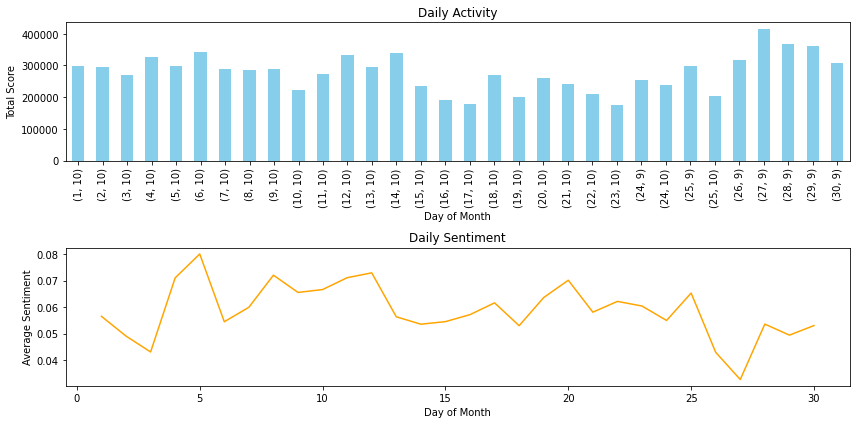

In [18]:
import matplotlib.pyplot as plt

# Assuming you have previously created 'daily_activity' and 'daily_sentiment' Series

# Set the figure size
plt.figure(figsize=(12, 6))

# Daily Activity
plt.subplot(2, 1, 1)
daily_activity.plot(kind='bar', color='skyblue')
plt.title('Daily Activity')
plt.xlabel('Day of Month')
plt.ylabel('Total Score')

# Daily Sentiment
plt.subplot(2, 1, 2)
daily_sentiment.plot(kind='line', color='orange')
plt.title('Daily Sentiment')
plt.xlabel('Day of Month')
plt.ylabel('Average Sentiment')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

Language Complexity analysis

In [19]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.probability import FreqDist

# Download NLTK resources (if not already downloaded)
nltk.download('punkt') # pretrained - tokenizer model

def language_complexity(comment):
    # Tokenize the comment into sentences and words
    sentences = sent_tokenize(comment)
    words = word_tokenize(comment)

    # Calculate average sentence length
    avg_sentence_length = len(words) / len(sentences)

    # Calculate average word length
    avg_word_length = sum(len(word) for word in words) / len(words)

    # Calculate Type-Token Ratio (TTR)
    ttr = len(set(words)) / len(words) #ratio of the number of unique words to total number of words

    # Print the results
    # print(f"Average Sentence Length: {avg_sentence_length}")
    # print(f"Average Word Length: {avg_word_length}")
    # print(f"Type-Token Ratio (TTR): {ttr}")
    
    return avg_sentence_length, avg_word_length, ttr

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kedar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
data_comments[['avg_length_sentence', 'avg_word_length', 'ttr']] = data_comments['body'].apply(
    lambda x: pd.Series(language_complexity(x), index=['avg_length_sentence', 'avg_word_length', 'ttr']))

In [21]:
data_comments.head()

,subreddit.name,created_utc,body,score,Sentiment_Score,hour,day_of_week,day_of_month,month,year,avg_length_sentence,avg_word_length,ttr
999999,warriors,2021-09-24 07:52:48+00:00,"The only hope to be rid of covid, or make it m...",0,0.4404,7,4,24,9,2021,13.800000,3.884058,0.623188
999998,askreddit,2021-09-24 07:52:58+00:00,New management that made the work terrible. I ...,1,0.5859,7,4,24,9,2021,12.333333,3.810811,0.837838
999997,leopardsatemyface,2021-09-24 07:53:02+00:00,She'll blame this on COVID.,2,-0.3400,7,4,24,9,2021,7.000000,3.285714,1.000000
999996,malaysia,2021-09-24 07:53:07+00:00,"Hi, why is Selangor covid can't deep into with...",-13,0.0000,7,4,24,9,2021,11.333333,3.294118,0.882353
999995,travelhacks,2021-09-24 07:53:10+00:00,I used the binaxnow rapid to get into Croatia ...,1,0.3182,7,4,24,9,2021,15.333333,4.260870,0.782609


Combining Datasets

In [22]:
data_comments.rename(columns={'year': 'Year'}, inplace=True)
data_comments.rename(columns={'month': 'Month'}, inplace=True)
data_comments.rename(columns={'day_of_month': 'Day'}, inplace=True)

daily_comments = data_comments.groupby(['Year', 'Month', 'Day']).agg({
    'body': 'count',               # Count of comments on the day
    'score': 'sum',                # Sum of scores on the day
    'Sentiment_Score': 'mean',     # Average sentiment score on the day
    'avg_length_sentence': 'mean', # Average length of sentence on the day
    'avg_word_length': 'mean',     # Average word length on the day
    'ttr': 'mean'                  # Average Type-Token Ratio on the day
    # Add more aggregation as needed
}).reset_index()

# Merge DataFrames based on common columns 'Year', 'Month', and 'Day'
combined_data = pd.merge(daily_comments, daily_stats, on=['Year', 'Month', 'Day'])

# Calculate the percentage of outbreak for each day
combined_data['Percentage_outbreak'] = (combined_data['Cumulative_cases'] / total_population) * 100
combined_data.drop('Outbreak_Risk', axis=1, inplace=True)

# Display the combined DataFrame
print(combined_data)

    Year  Month  Day   body   score  Sentiment_Score  avg_length_sentence  \
0   2021      9   24  25846  253766         0.057823            19.966824   
1   2021      9   25  30203  297809         0.054709            19.687297   
2   2021      9   26  31780  316551         0.042931            19.773309   
3   2021      9   27  37603  415261         0.032665            19.815857   
4   2021      9   28  38477  367523         0.053573            20.072293   
5   2021      9   29  38135  360962         0.049408            20.074829   
6   2021      9   30  36115  308130         0.053018            19.965721   
7   2021     10    1  34178  299455         0.056503            20.015219   
8   2021     10    2  29218  295401         0.049048            19.781243   
9   2021     10    3  30236  269228         0.043060            19.806721   
10  2021     10    4  33580  327335         0.071005            20.288691   
11  2021     10    5  32804  297101         0.080026            20.031035   

In [23]:
nan_combined_data = combined_data.isna().sum()
print(nan_combined_data)

Year                   0
Month                  0
Day                    0
body                   0
score                  0
Sentiment_Score        0
avg_length_sentence    0
avg_word_length        0
ttr                    0
New_cases              0
Cumulative_cases       0
New_deaths             0
Cumulative_deaths      0
Percentage_outbreak    0
dtype: int64


MODELS

linear regression & Ridge regression

R-squared (Linear Regression): 1.0000
Mean Squared Error (MSE) (Linear Regression): 0.0000
R-squared (Ridge Regression): 1.0000
Mean Squared Error (MSE) (Ridge Regression): 0.0000
Best alpha for Ridge Regression: 0.000001


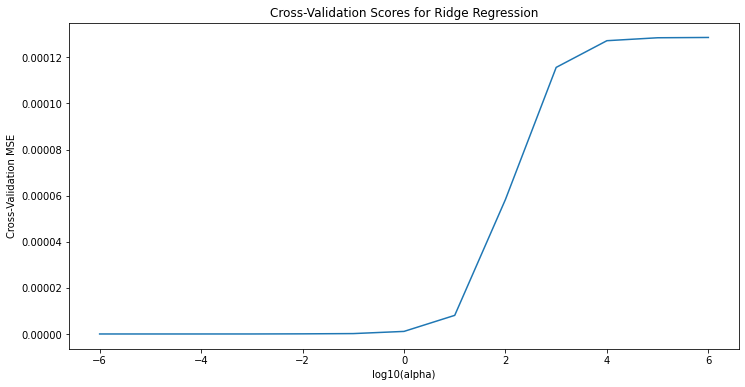

In [31]:
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize features - ensuring features have a mean =0 and standard deviation = 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Evaluate Linear Regression model
r_squared_lr = r2_score(y_test, lr_predictions)
mse_lr = mean_squared_error(y_test, lr_predictions)
print(f'R-squared (Linear Regression): {r_squared_lr:.4f}')
print(f'Mean Squared Error (MSE) (Linear Regression): {mse_lr:.4f}')

# Ridge Regression with Cross-Validation - regularization term
alphas = np.logspace(-6, 6, 13)  # range of alpha values logarithmically spaced
ridge_cv_scores = []

# applying ridge regression for all alpha values to find the tbe cross validated mean squared errors for selection of best alpha
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    cv_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_mse_cv = -np.mean(cv_scores)
    ridge_cv_scores.append(avg_mse_cv)

# minimum MSE = Best alpha
best_alpha = alphas[np.argmin(ridge_cv_scores)]

# Train the Ridge model with the best alpha
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_scaled, y_train)
ridge_predictions = ridge_model.predict(X_test_scaled)

# Evaluate Ridge Regression model
r_squared_ridge = r2_score(y_test, ridge_predictions)
mse_ridge = mean_squared_error(y_test, ridge_predictions)
print(f'R-squared (Ridge Regression): {r_squared_ridge:.4f}')
print(f'Mean Squared Error (MSE) (Ridge Regression): {mse_ridge:.4f}')
print(f'Best alpha for Ridge Regression: {best_alpha:.6f}')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=np.log10(alphas), y=ridge_cv_scores)
plt.title('Cross-Validation Scores for Ridge Regression')
plt.xlabel('log10(alpha)')
plt.ylabel('Cross-Validation MSE')
plt.show()

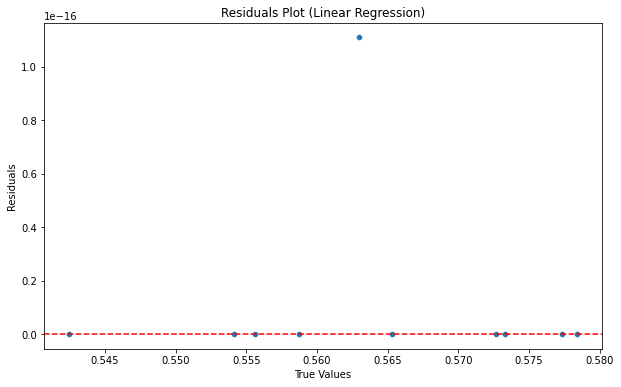

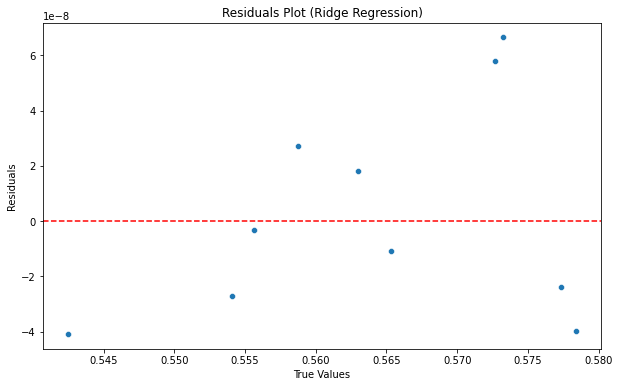

In [51]:
# Residual Plot for Linear Regression
residuals_lr = y_test - lr_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals_lr)
plt.title('Residuals Plot (Linear Regression)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Residual Plot for Ridge Regression
residuals_ridge = y_test - ridge_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals_ridge)
plt.title('Residuals Plot (Ridge Regression)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Residual plot interpretation:
1) Random Distribution: Ideally, residuals should be randomly scattered around the horizontal axis with no clear pattern. This indicates that the model is capturing the underlying patterns in the data well. - exhibits independent relationships between variables
2) Line at Zero: A horizontal line at zero on the y-axis indicates that, on average, the model is neither overestimating nor underestimating the true values.


Conclusions:
since R squared error and MSE are 1 and 0 respectively, this suggests overfitting of the model.
1) linear  models overfit with high dimensional data specifically when there are multiple features
2) ridge regression is sensitive to outliers - regularization term might not be sufficient
3) cannot pick and choose features, utilises all features provided.
4) data is non-linear

SVM - Regression 

Best Parameters: {'C': 0.01, 'epsilon': 0.01}
R-squared (SVM): 0.3252
Mean Squared Error (MSE) (SVM): 0.0001


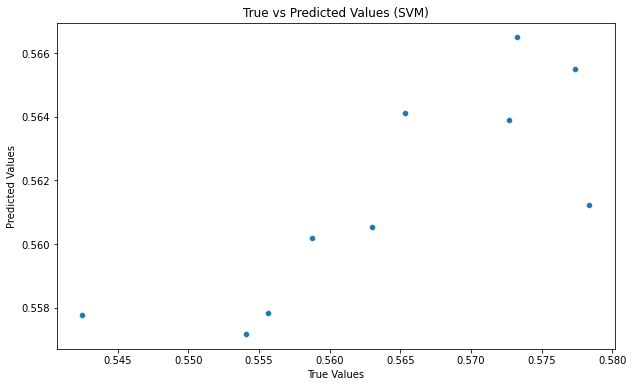

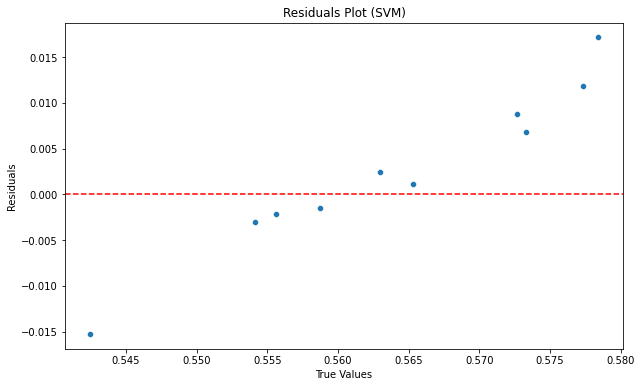

In [52]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Create an SVM model
svm_model = SVR(kernel = 'rbf')

# Define a parameter grid for GridSearchCV
# c- regularization parameter to control tradeoff between bias and variance
# epsilon - defines margin of tolerance within which errors are not accepted.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.2, 0.5, 1]}

# Use GridSearchCV to find the best parameters - hyperparameter tuning
# - mse
# 5- fold cross validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create an SVM model with the best parameters
best_svm_model = SVR(C=best_params['C'], epsilon=best_params['epsilon'])

# Fit the model to the training data
best_svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
svm_predictions = best_svm_model.predict(X_test_scaled)

# Evaluate the model
r_squared_svm = r2_score(y_test, svm_predictions)
mse_svm = mean_squared_error(y_test, svm_predictions)

print(f'R-squared (SVM): {r_squared_svm:.4f}')
print(f'Mean Squared Error (MSE) (SVM): {mse_svm:.4f}')

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=svm_predictions)
plt.title('True vs Predicted Values (SVM)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residuals plot
residuals = y_test - svm_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.title('Residuals Plot (SVM)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



conclusions:
1) R-squared (SVM): 0.3252, Mean Squared Error (MSE) (SVM): 0.0001 this suggests an underfitting model
2) sensitive to outliers which is why it underfits

KNN

R-squared (Ensemble with KNN): 0.7224
Mean Squared Error (MSE) (Ensemble with KNN): 0.0000


c:\Users\kedar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


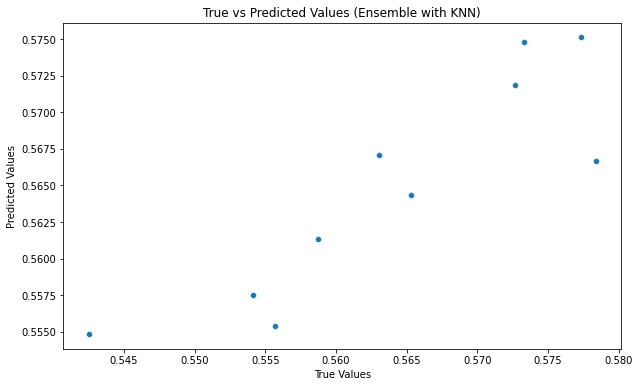

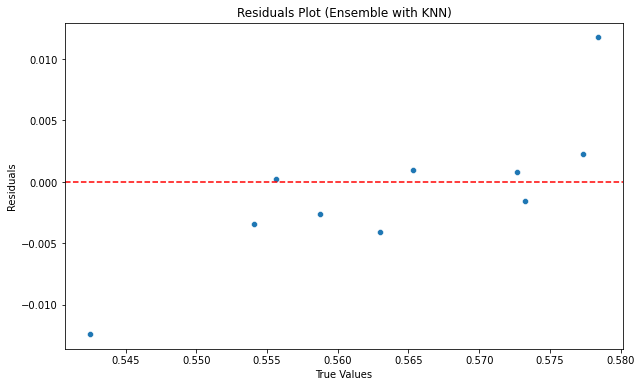

In [35]:
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Create a Decision Trees model ensembled with KNN
knn_model = KNeighborsRegressor()
ensemble_model = BaggingRegressor(base_estimator=knn_model, n_estimators=10, random_state=42)

# Fit the model to the training data
ensemble_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
ensemble_predictions = ensemble_model.predict(X_test_scaled)

# Evaluate the model
r_squared_ensemble = r2_score(y_test, ensemble_predictions)
mse_ensemble = mean_squared_error(y_test, ensemble_predictions)

print(f'R-squared (Ensemble with KNN): {r_squared_ensemble:.4f}')
print(f'Mean Squared Error (MSE) (Ensemble with KNN): {mse_ensemble:.4f}')

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=ensemble_predictions)
plt.title('True vs Predicted Values (Ensemble with KNN)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residuals plot
ensemble_residuals = y_test - ensemble_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=ensemble_residuals)
plt.title('Residuals Plot (Ensemble with KNN)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

conclusions: 
- R-squared (Ensemble with KNN): 0.7224, Mean Squared Error (MSE) (Ensemble with KNN): 0.0000 suggests a good fit of the model
- decision tree make good global decisions and KNNs manage good local decisions



Random Forest

R-squared (Random Forest): 0.7762
Mean Squared Error (MSE) (Random Forest): 0.0000


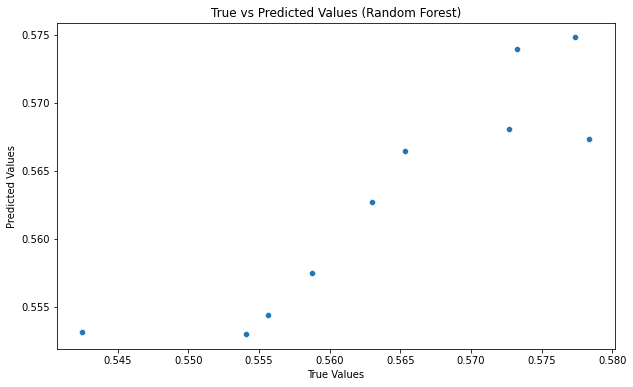

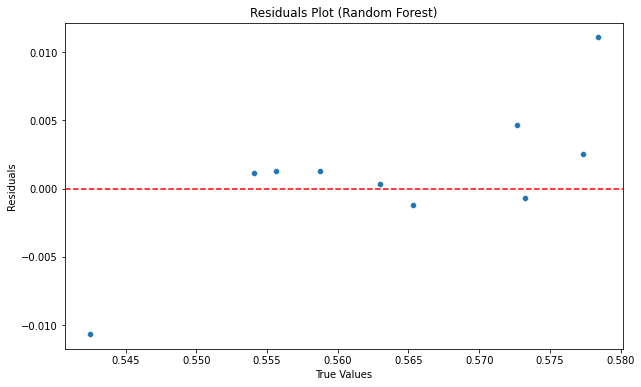

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Use a RandomForestRegressor with adjusted parameters
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features="sqrt", random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluate the model
r_squared_rf = r2_score(y_test, rf_predictions)
mse_rf = mean_squared_error(y_test, rf_predictions)

print(f'R-squared (Random Forest): {r_squared_rf:.4f}')
print(f'Mean Squared Error (MSE) (Random Forest): {mse_rf:.4f}')

# Scatter plot of true vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_predictions)
plt.title('True vs Predicted Values (Random Forest)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residuals plot
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_residuals)
plt.title('Residuals Plot (Random Forest)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

conclusions: 
- R-squared (Random Forest): 0.7762, Mean Squared Error (MSE) (Random Forest): 0.0000 suggests The best fit compared to all the models
- subset of features (randomized) 
- robust to missing values
- feature importance


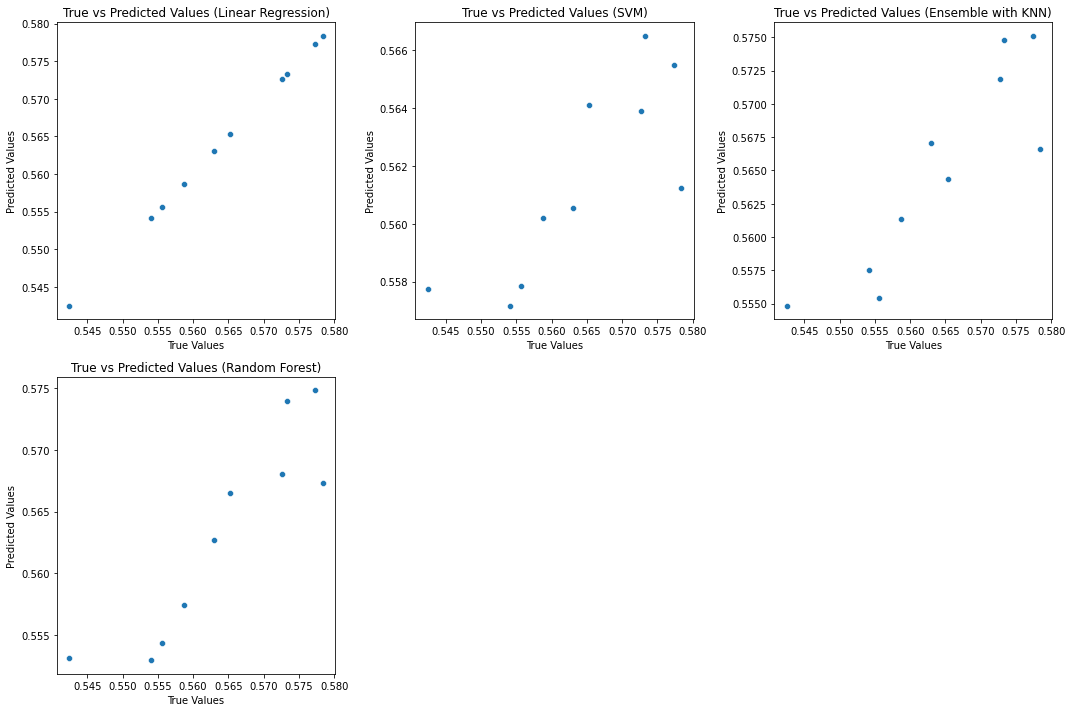

In [40]:
# Scatter plot of true vs predicted values for all models
plt.figure(figsize=(15, 10))

# Linear Regression
plt.subplot(2, 3, 1)
sns.scatterplot(x=y_test, y=lr_predictions)
plt.title('True vs Predicted Values (Linear Regression)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# SVM
plt.subplot(2, 3, 2)
sns.scatterplot(x=y_test, y=svm_predictions)
plt.title('True vs Predicted Values (SVM)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Ensemble with KNN
plt.subplot(2, 3, 3)
sns.scatterplot(x=y_test, y=ensemble_predictions)
plt.title('True vs Predicted Values (Ensemble with KNN)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Random Forest
plt.subplot(2, 3, 4)
sns.scatterplot(x=y_test, y=rf_predictions)
plt.title('True vs Predicted Values (Random Forest)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [44]:
from sklearn.model_selection import cross_val_score

# Define the models
ensemble_model = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=10, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, max_features="sqrt", random_state=42)

# Perform cross-validation
cv_scores_ensemble = cross_val_score(ensemble_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive (since 'neg_mean_squared_error' returns negative values)
cv_scores_ensemble = -cv_scores_ensemble
cv_scores_rf = -cv_scores_rf

# Print average scores
print(f'Ensemble with KNN - Average MSE: {cv_scores_ensemble.mean():.20f}')
print(f'Random Forest - Average MSE: {cv_scores_rf.mean():.20f}')

## final model is random forest

c:\Users\kedar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\kedar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\kedar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\kedar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\kedar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: Futu

Ensemble with KNN - Average MSE: 0.00003731281110014121
Random Forest - Average MSE: 0.00001946175304530501


conclusion:
final cross validation (after calculating average MSE): random forest regression has a lower MSE than Decision Tree Ensemble with KNN hence making it the best fitting model